# BATTLE OF NEIGHBORHOOD - FINAL PROJECT

### Checking average prices and school ratings.

Scarborough is a famous goal for new workers in Canada to live. Subsequently, it is a standout amongst the most different and multicultural territories in the Greater Toronto Area, being home to different religious gatherings and spots of love.

The tasks plan to make an investigation of highlights for an area or a near examination between neighborhoods with simply conveying the names of the areas. The highlights incorporate populace rate, middle house value, school evaluations, wrongdoing rates, climate conditions, recreational offices. This would help individuals to get the familiarity with the spots before moving to another nation, state, city or spot for their work or to begin another life.

This Project would enable clients to take a superior choice on picking the best neighborhood out of numerous areas to move into NewYork city dependent on the appropriation of different offices in and around that area.

In [1]:
# Importing libraries
from bs4 import BeautifulSoup
import requests
import csv
import json
import xml
import pandas as pd
import geocoder
import matplotlib.pyplot as plt
%matplotlib inline
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import warnings
warnings.filterwarnings("ignore")

#### Web Scraping

In [2]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml') #Parsing webpage
table=soup.find('table')
x=table.tbody

postcode = 0
borough = 0
neighborhood = 0

for tr in x.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2:
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)
    
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
                                 
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()


df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]


def list_of_neighbor(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(list_of_neighbor).reset_index(name='Neighborhood')

Getting latitudes and longitudes

In [3]:
def lat_lang(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords

postal_codes = df2['Postalcode']    
coords = [ lat_lang(postal_code) for postal_code in postal_codes.tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [4]:
df = df.head(17)
df.shape

(17, 5)

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of Scarborough,Toronto are 43.773077, -79.257774.


#### Creating Map

In [30]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)
# incidents = folium.map.FeatureGroup()
# # add markers to map
# for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
#     label = '{}'.format(nei)
#     label = folium.Popup(label, parse_html=True)
#     incidents.add_child(
#         folium.features.CircleMarker(
#             [lat, lng],
#              radius=5,
#              popup=label,
#              color='blue',
#              fill=True,
#              fill_color='#3186cc',
#              fill_opacity=0.7,
#              parse_html=False).add_to(map_Scarborough)
#      )
    
map_Scarborough

In [31]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The geograpical coordinate of neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of neighborhood_1 are 43.773077, -79.257774.


In [32]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = ''
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [33]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [34]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Nearby Neighborhood Venues

In [35]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(5)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,American Eagle Outfitters,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775908,-79.258352
2,Canyon Creek Chophouse,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",43.776959,-79.261694
3,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
4,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776613,-79.258516


Getting details of venues

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge


In [38]:
print('There are {} uniques categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 76 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,31,31,31,31,31,31
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Birch Cliff, Cliffside West",9,9,9,9,9,9
Cedarbrae,8,8,8,8,8,8
"Clairlea, Golden Mile, Oakridge",19,19,19,19,19,19


In [39]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Neighborhood,American Restaurant,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,Bakery,Bank,Bar,Big Box Store,Bistro,Breakfast Spot,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Business Service,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Convenience Store,Deli / Bodega,Department Store,Diner,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Fried Chicken Joint,Furniture / Home Store,General Entertainment,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hobby Shop,Indian Restaurant,Intersection,Liquor Store,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motorcycle Shop,Other Great Outdoors,Park,Pet Store,Pharmacy,Pizza Place,Pool,Print Shop,Restaurant,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Shopping Mall,Skating Rink,Soccer Field,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Thrift / Vintage Store,Train Station,Video Game Store,Vietnamese Restaurant,Zoo Exhibit
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                venue  freq
0       Shopping Mall  0.10
1  Chinese Restaurant  0.10
2         Supermarket  0.06
3      Discount Store  0.03
4         Coffee Shop  0.03


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                      venue  freq
0                  Pharmacy  0.67
1            Sandwich Place  0.33
2       American Restaurant  0.00
3  Mediterranean Restaurant  0.00
4                      Park  0.00


----Birch Cliff, Cliffside West----
                   venue  freq
0                   Park  0.33
1                    Gym  0.11
2               Gym Pool  0.11
3  General Entertainment  0.11
4                   Café  0.11


----Cedarbrae----
                venue  freq
0  Athletics & Sports  0.12
1   Indian Restaurant  0.12
2              Bakery  0.12
3                Bank  0.12
4    Hakka Restaurant  0.12


----Clairlea, Golden Mile, Oakridge----
          venue  freq
0  Intersection  0.16
1         Diner  0.11
2   Coffee Shop  0.11
3

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Most common venues

In [42]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Supermarket,American Restaurant,Pool,Discount Store,Department Store,Vietnamese Restaurant,Coffee Shop,Malay Restaurant
1,"Agincourt North, L'Amoreaux East, Milliken, St...",Pharmacy,Sandwich Place,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Convenience Store,Deli / Bodega,Department Store,Diner
2,"Birch Cliff, Cliffside West",Park,General Entertainment,Gym Pool,Café,College Stadium,Skating Rink,Gym,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
3,Cedarbrae,Indian Restaurant,Caribbean Restaurant,Athletics & Sports,Thai Restaurant,Flower Shop,Bakery,Bank,Hakka Restaurant,Electronics Store,Convenience Store
4,"Clairlea, Golden Mile, Oakridge",Intersection,Bus Line,Bakery,Coffee Shop,Diner,Park,Gym,General Entertainment,Convenience Store,Fast Food Restaurant


#### k-means Clustering

In [43]:
# set number of clusters
# Using k-means to cluster the neighborhood into 3 clusters.
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [44]:
Scarborough_merged =df.iloc[:16,:]
# add clustering labels
Scarborough_merged['Cluster Labels'] = kmeans.labels_
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Scarborough_merged.head()# check the last column

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517,0,Zoo Exhibit,Fast Food Restaurant,Business Service,Electronics Store,Farmers Market,Fried Chicken Joint,Flower Shop,Fish & Chips Shop,Furniture / Home Store,Chinese Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785730,-79.158750,2,Bar,Fish & Chips Shop,Zoo Exhibit,Electronics Store,College Stadium,Convenience Store,Deli / Bodega,Department Store,Diner,Discount Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175256,0,Park,Gym,Athletics & Sports,Gym / Fitness Center,Discount Store,Coffee Shop,College Stadium,Convenience Store,Deli / Bodega,Department Store
3,M1G,Scarborough,Woburn,43.768359,-79.217590,0,Coffee Shop,Park,Business Service,Fast Food Restaurant,Discount Store,College Stadium,Convenience Store,Deli / Bodega,Department Store,Diner
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440,0,Indian Restaurant,Caribbean Restaurant,Athletics & Sports,Thai Restaurant,Flower Shop,Bakery,Bank,Hakka Restaurant,Electronics Store,Convenience Store


#### Cluster maps

In [45]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)
kclusters = 3
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Scarborough_merged['Latitude'], Scarborough_merged['Longitude'], Scarborough_merged['Neighborhood'],Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [46]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

#### PRICES OF HOUSES

In [54]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0]})

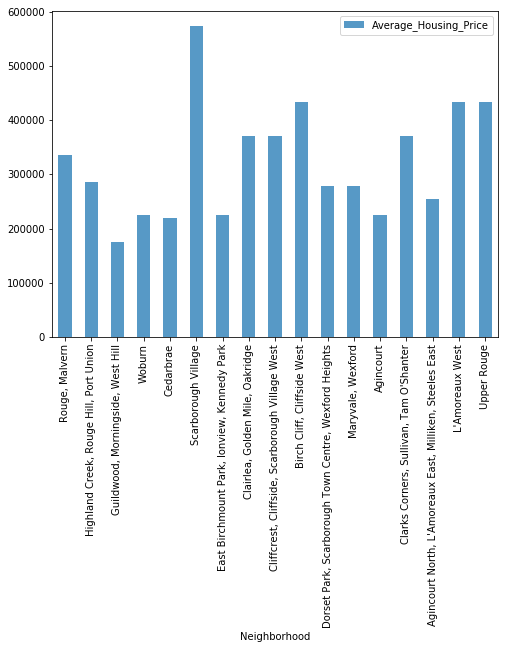

In [55]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(8,6),alpha=0.75)

#### Cluster of School Rating

In [56]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [57]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,]})

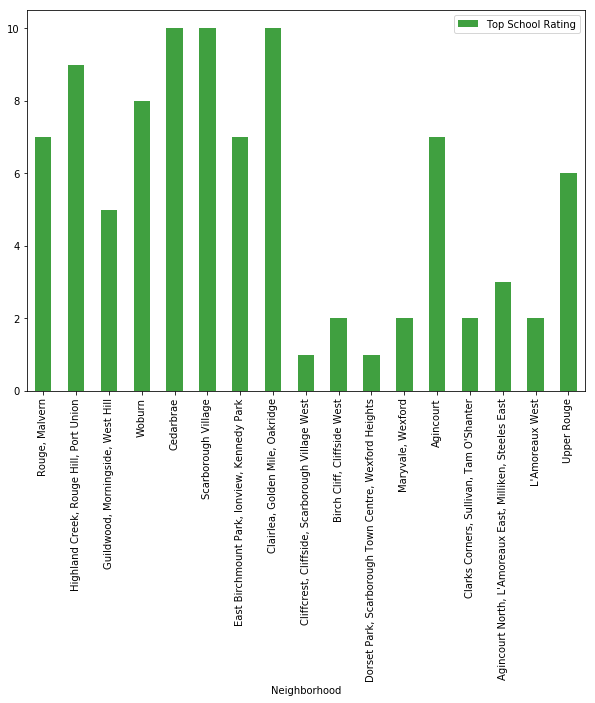

In [58]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_school_ratings.plot(kind='bar',figsize=(10,7),color='green',alpha=0.75);

### Final Words

In this task, through a k-implies group calculation, we separate the area into 03 bunches, which have comparable neighborhoods around them. Utilizing the outlines above choice wanting to a specific neighborhood dependent all things considered house costs and school rating can be made.